# Explore the 001 Model Run
- Include static variables
- run the ealstm too

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.utils import get_data_path
from src.engineer import Engineer

In [3]:
WARNINGS_ON = False

if not WARNINGS_ON:
    print("WARNING: You are turning off all warnings. Are you sure?")
    import warnings
    warnings.filterwarnings('ignore')

In [4]:
from src.utils import get_ds_mask

data_dir = get_data_path()

# Model Run

In [5]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from scripts.analysis import read_all_data, read_all_available_pred_data, load_nn, create_all_error_metrics

In [7]:
# ealstm = load_nn(data_dir, model_str="ealstm", experiment=experiment)
# ealstm.ignore_vars
model = load_nn(data_dir, model_str="rnn", experiment=experiment)
ignore_vars = model.ignore_vars

In [8]:
# read train/test data
X_train, y_train, X_test, y_test = read_all_data(
    data_dir, static=True, experiment=experiment
)

mask = get_ds_mask(X_train.VCI)
test_da = y_test[list(y_test.data_vars)[0]]

In [9]:
# read the predicted data
predictions = read_all_available_pred_data(data_dir, experiment=experiment)

# predictions = {}
# for model in ["previous_month", "linear_network", "rnn"]:
#     da = xr.open_dataset(data_dir / f"000_models/one_month_forecast/{model}_preds.nc")
#     predictions[model] = da[[v for v in da.data_vars][0]]

#  check that the shapes of all predictions are the same
assert set([predictions[m].shape for m in predictions.keys()]).__len__() == 1
preds = predictions[list(m for m in predictions.keys())[0]]

# get the matching shapes from predictions and test data
test_da = test_da.sel(lat=preds.lat, lon=preds.lon, time=preds.time)

### Calculate Error Metrics

In [10]:
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)

In [127]:
import pickle

def pickle_file(obj, filepath: Path):
    assert not filepath.exists(), "Expect the file to save not to exist!"
    assert filepath.parents[0].exists(), "Expect the parent directory to exist!"
    
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
        
        
# pickle_file(r2_dict, data_dir / "tommy/001_one_month_forecast_r2_dict.pkl")
# pickle_file(rmse_dict, data_dir / "tommy/001_one_month_forecast_rmse_dict.pkl")
# pickle_file(predictions, data_dir / "tommy/001_one_month_forecast_preds_dict.pkl")

In [82]:
pd.DataFrame({
    "model": [model for (model, da) in r2_dict.items()],
    "median_r2": [float(da.median().values) for (model, da) in r2_dict.items()]
})

,model,median_r2
0,previous_month,0.504001
1,rnn,0.626832
2,ealstm,0.659670


In [124]:
pd.DataFrame({
    "model": [model for (model, da) in rmse_dict.items()],
    "median_rmse": [float(da.median().values) for (model, da) in rmse_dict.items()]
})

,model,median_rmse
0,previous_month,17.224864
1,rnn,15.205261
2,ealstm,14.564012


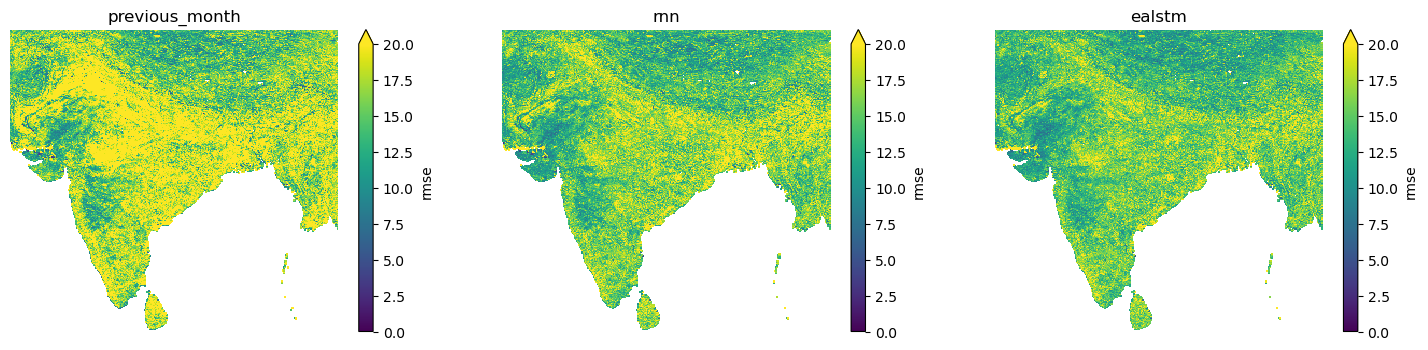

In [11]:
kwargs = dict(vmin=0, vmax=20, cmap="viridis")

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, key in enumerate(rmse_dict.keys()):
    ax = axs[i]
    rmse_dict[key].plot(ax=ax, **kwargs)
    ax.set_title(str(key))  
    ax.axis('off')

In [131]:
rmse_dict.keys()

dict_keys(['previous_month', 'rnn', 'ealstm'])

(67.25000381469727, 97.74999618530273, 5.700000286102295, 36.04999923706055)

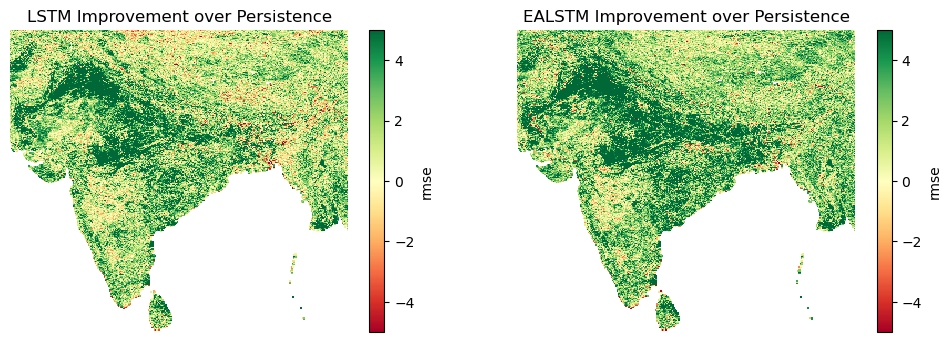

In [144]:
kwargs = dict(cmap="RdYlGn", vmin=-5, vmax=5)
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

ax = axs[0]
(rmse_dict["previous_month"] - rmse_dict["rnn"]).plot(ax=ax, cbar_kwargs=dict(extend='neither'), **kwargs)
ax.set_title("LSTM Improvement over Persistence")
ax.axis('off')

ax = axs[1]
(rmse_dict["previous_month"] - rmse_dict["ealstm"]).plot(ax=ax,cbar_kwargs=dict(extend='neither'),  **kwargs)
ax.set_title("EALSTM Improvement over Persistence")
ax.axis('off')

# Join Metrics to Region DataFrame

In [12]:
l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")
l2_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm2.shp")

l1_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")
l2_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")

l1_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l1_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l1_mask.attrs["values"].split(',')]
))
l2_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l2_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l2_mask.attrs["values"].split(',')]
))

### Creating the R2/RMSE GeoDataFrames

In [13]:
from scripts.analysis import get_mean_timeseries_per_region

In [14]:
assert (data_dir / "tommy").exists(), "Require data_dir / 'tommy' to save csv copy of data"

# takes a while to run so save it if it doesn't exist already
if not (data_dir / "tommy/l1_state_mean_timeseries_001.csv").exists():
    state_df = get_mean_timeseries_per_region(level=1)
    state_df.to_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv")
else:
    state_df = pd.read_csv(data_dir / "tommy/l1_state_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [15]:
if not (data_dir / "tommy/l2_district_mean_timeseries_001.csv").exists():
    district_df = get_mean_timeseries_per_region(level=2)
    district_df.to_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv")
else:
    district_df = pd.read_csv(data_dir / "tommy/l2_district_mean_timeseries_001.csv").drop("Unnamed: 0", axis=1)

In [16]:
from scripts.analysis import create_mean_pixel_errors_gdf

In [17]:
## -- Level 1 --
l1_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)

l1_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)


## -- Level 2 --
l2_rmse_gdf = create_mean_pixel_errors_gdf(
    metric_dict=rmse_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

l2_r2_gdf = create_mean_pixel_errors_gdf(
    metric_dict=r2_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

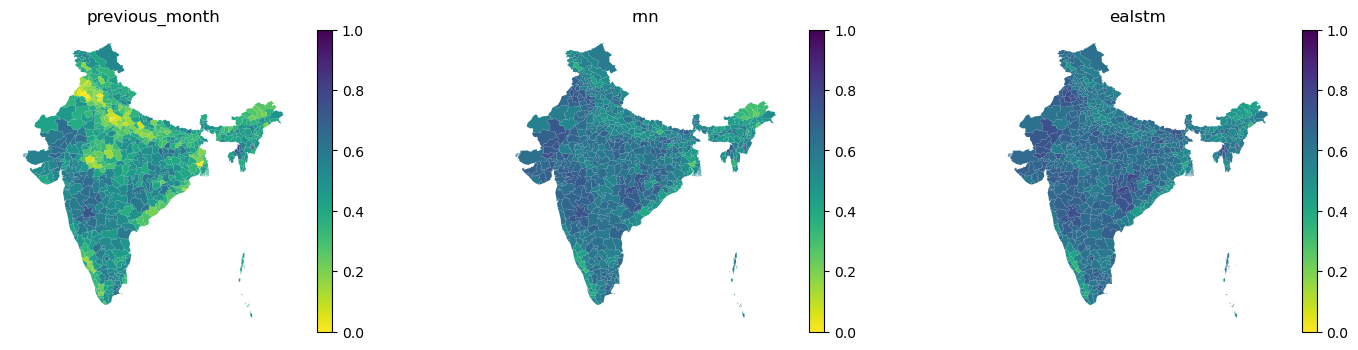

In [18]:
kwargs = {"vmin": 0, "vmax": 1, "cmap": "viridis_r"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_r2_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

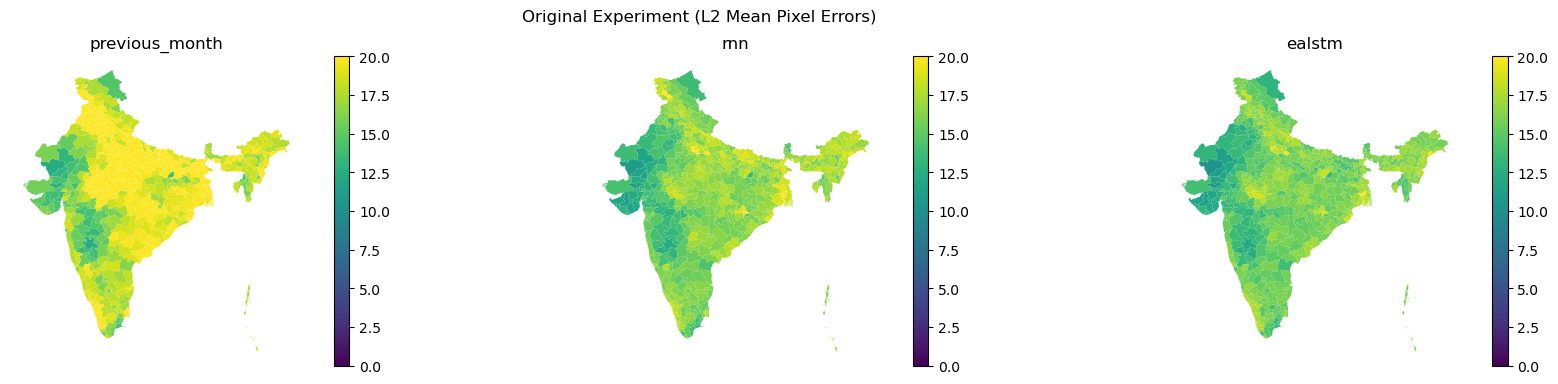

In [130]:
kwargs = {"vmin": 0, "vmax": 20, "cmap": "viridis"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_rmse_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

fig.suptitle("Original Experiment (L2 Mean Pixel Errors)")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Mean of Predictions per Area

In [20]:
from scripts.analysis import calculate_error_of_mean_predictions

In [21]:
l1_mean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = state_df,
    region_gdf = l1_gdf,
    gdf_name_col = "NAME_1",
    monthly_averages = False
)

l1_mean_pred_scores

,model,rmse,r2_score,geometry
Andaman and Nicobar,ealstm,10.793724,0.217171,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
Andaman and Nicobar,previous_month,11.180127,0.160119,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
Andaman and Nicobar,rnn,11.218986,0.154271,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
Andhra Pradesh,ealstm,5.124353,0.648648,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13..."
Andhra Pradesh,previous_month,6.118271,0.499134,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13..."
...,...,...,...,...
Uttaranchal,previous_month,7.956173,0.036018,"POLYGON ((79.19478 31.35362, 79.19817 31.35196..."
Uttaranchal,rnn,6.413939,0.373516,"POLYGON ((79.19478 31.35362, 79.19817 31.35196..."
West Bengal,ealstm,6.831956,0.538554,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21..."
West Bengal,previous_month,8.325022,0.314824,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21..."


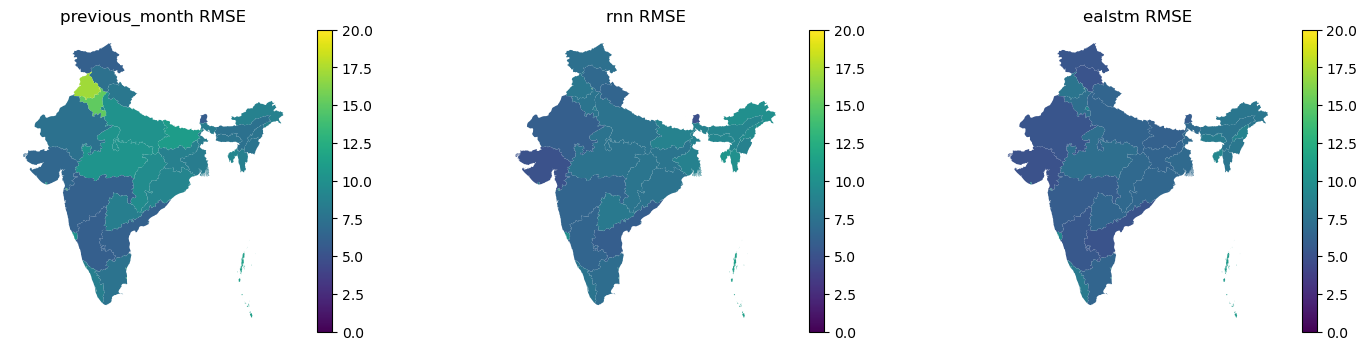

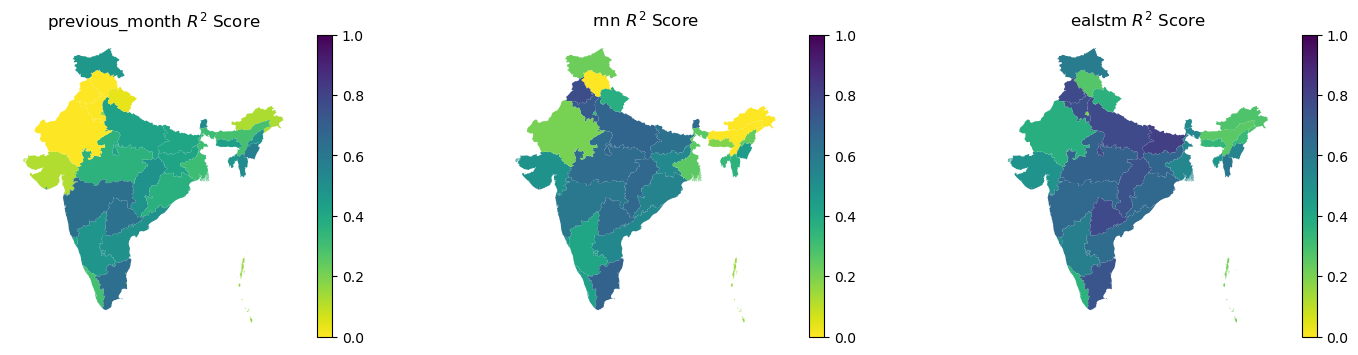

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))

for ix, model in enumerate(["previous_month","rnn", "ealstm"]):
    ax = axs[ix]
    l1_mean_pred_scores.loc[l1_mean_pred_scores["model"] == model].plot("rmse", legend=True, vmin=0, vmax=20, ax=ax)
    ax.axis('off')
    ax.set_title(f"{model} RMSE")
    
fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for ix, model in enumerate(["previous_month", "rnn", "ealstm"]):
    ax = axs[ix]
    l1_mean_pred_scores.loc[l1_mean_pred_scores["model"] == model].plot("r2_score", legend=True, vmin=0, vmax=1, ax=ax, cmap="viridis_r")
    ax.axis('off')
    ax.set_title(f"{model} $R^2$ Score")

# Creating seasonal errors

### Mean of Predictions per month
$$error ( \texttt{spacetime_mean}(obs), \texttt{spacetime_mean}(pred) ) $$

In [23]:
l1_monmean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = state_df,
    region_gdf = l1_gdf,
    gdf_name_col = "NAME_1",
    monthly_averages = True
)
l1_monmean_pred_scores["month"] = l1_monmean_pred_scores["datetime"].astype(int)

l2_monmean_pred_scores = calculate_error_of_mean_predictions(
    region_mean_df = district_df,
    region_gdf = l2_gdf,
    gdf_name_col = "NAME_2",
    monthly_averages = True
)
l2_monmean_pred_scores["month"] = l2_monmean_pred_scores["datetime"].astype(int)

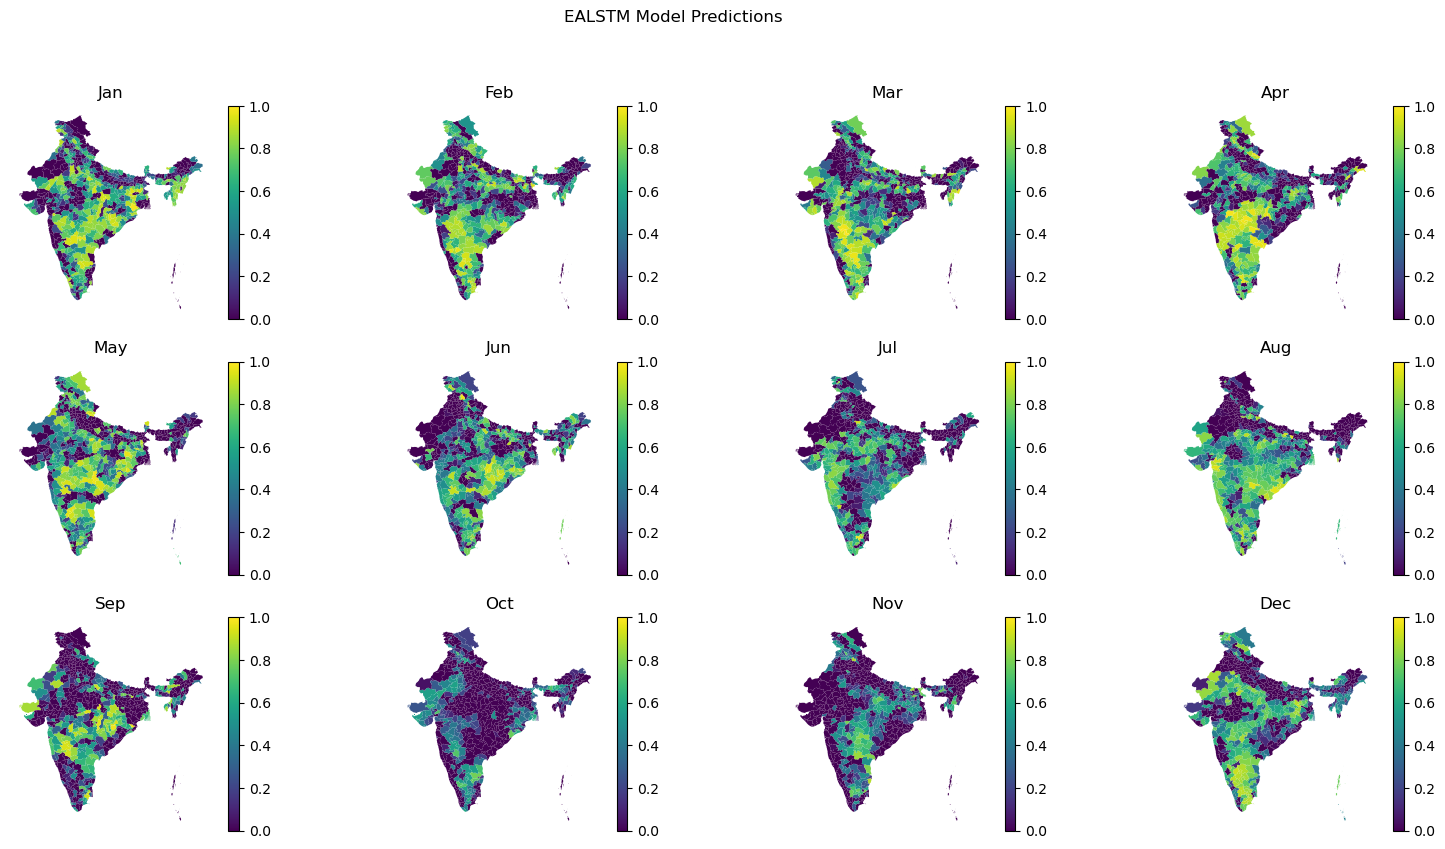

In [24]:
import calendar 
scale = 0.8
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in range(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    l2_monmean_pred_scores.query(f"(model == 'ealstm') & month == {mth}").plot("r2_score", vmin=0, vmax=1, legend=True, ax=ax)
    ax.axis('off')
    ax.set_title(calendar.month_abbr[mth])
    
fig.suptitle("EALSTM Model Predictions");

### Mean of Pixel Errors per month
$$ mean( error(obs, pred) ) $$

In [25]:
from scripts.analysis import create_all_temporal_error_metrics
from src.utils import drop_nans_and_flatten

In [26]:
pixel_mon_rmse, pixel_mon_r2 = create_all_temporal_error_metrics(
    predictions=predictions,
    y_test=test_da,
)
pixel_mon_rmse["ealstm"]

<xarray.DataArray 'rmse' (time: 12, lat: 302, lon: 305)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [14.31430048, 11.61398394, 13.34842255, ...,  8.10229831,
         10.2135455 , 19.67777295],
        [15.55568093, 22.71838799, 12.54796575, ..., 17.85259833,
         12.95566633,  6.35770845],
        [15.46053087, 21.43294994, 24.86419876, ...,  8.74166814,
         13.02062342, 17.42551406]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [18.70932183, 15.81740141,  6.95001441, ..., 11.41258031,
          6.19430534, 17.4810765 ],
        [22.18375329, 13.28986712, 12.13593761, ..., 15.49603199,
          8.78663332, 14.10831107],
        [ 8.30047844,  3.2775668 , 20.69122573, ..., 13.44068728,
         16.68748146, 16.56010287]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 6.30718473,  1.9995752 ,  5.57699933, ..., 14.46476378,
         26.63659739, 14.31590068],
        [ 3.91796628,  2.77789124,  7.81858757, ..., 13.74309386,
         13.72747579, 21.56596272],
        [11.29958076,  6.36120544, 23.59775705, ..., 19.87042427,
         12.03906693, 13.24029553]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [14.76634804,  3.9356531 ,  8.99849496, ..., 15.89943377,
         26.43650084,  6.10032751],
        [12.95078388, 16.17839996, 11.83449901, ...,  9.92735185,
          8.13394545,  9.55787505],
        [ 7.84206358, 17.26138789, 14.30390468, ...,  9.8364665 ,
          9.51543915,  7.91455029]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [11.21655227, 17.32470975, 12.57358661, ..., 25.01463926,
         20.93220088, 21.25852949],
        [ 8.83099813,  9.24194935,  9.89715911, ..., 26.56375529,
         29.70925025, 34.20449216],
        [12.18254963, 10.4255699 , 14.80454166, ..., 17.00537042,
         25.44604617, 22.49790238]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.42343649, 15.6117634 , 18.28904151, ..., 17.90609958,
         10.70663528,  9.77789342],
        [10.1250317 , 15.83141479, 19.38997505, ..., 11.04823194,
          3.7671724 ,  5.83394578],
        [ 6.34169333,  6.07555891, 18.79367777, ...,  4.33144033,
         13.58968369,  8.06948997]]])
Coordinates:
  * lat      (lat) float64 5.8 6.0 6.1 6.2 6.3 6.4 ... 35.6 35.7 35.8 35.9 36.0
  * lon      (lon) float64 67.3 67.4 67.5 67.6 67.7 ... 97.3 97.4 97.5 97.6

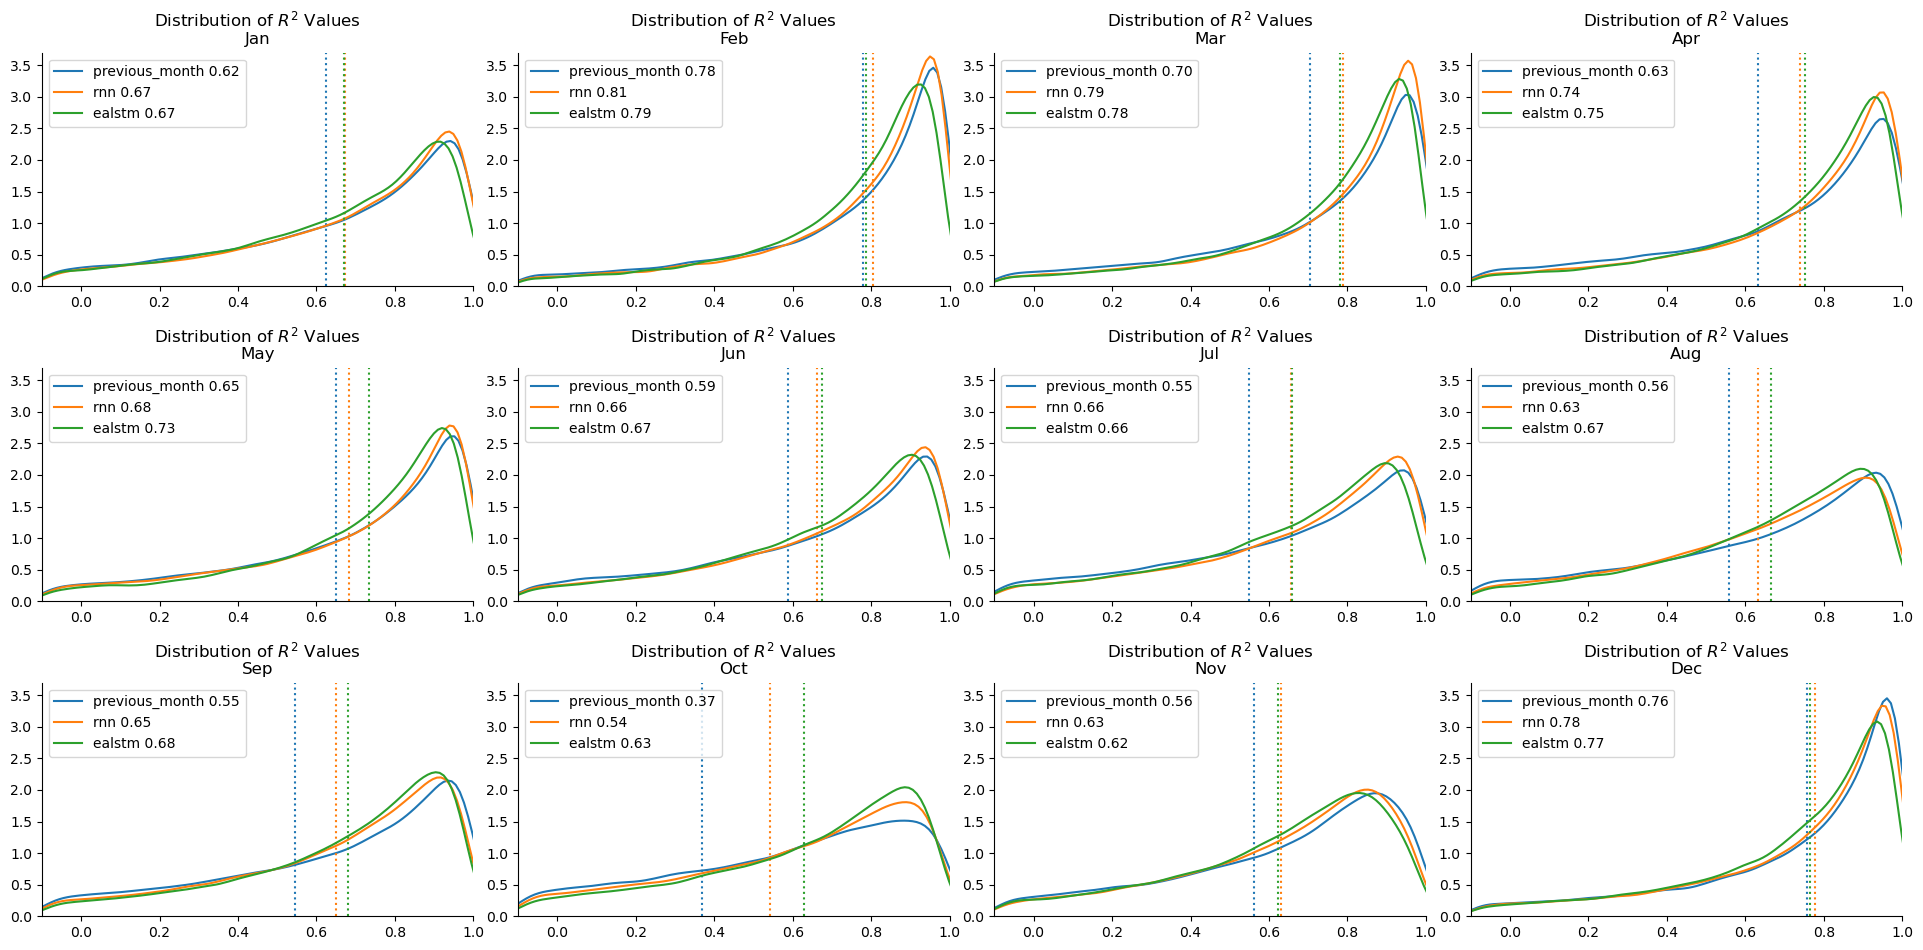

In [156]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_r2.keys()):
        model_r2 = pixel_mon_r2[model].sel(time=mth)
        color = sns.color_palette()[ix]
        median_score = float(model_r2.median().values)
        sns.distplot(
            drop_nans_and_flatten(model_r2), 
            hist=False,
            kde_kws={"clip": (-0.1, 1)}, 
            ax=ax, 
            label=f"{model} {median_score:.2f}", 
            color=color
        )
        ax.axvline(median_score, color=color, ls=":")

    ax.set_xlim(-0.1, 1)
    ax.set_ylim(0, 3.7)
    ax.set_title(f"Distribution of $R^2$ Values\n{calendar.month_abbr[mth]}")
    ax.legend()
    sns.despine()

plt.tight_layout()

## Animation ! :D 

In [168]:
def plot_month_r2_distribution(data_dict: Dict[str, xr.DataArray], mth: int, ax: Optional = None):    
    if ax is None:
        ax = plt.gca()
    fig = plt.gcf()
    
    for ix, model in enumerate(data_dict.keys()):
        model_r2 = data_dict[model].sel(time=mth)
        color = sns.color_palette()[ix]
        median_score = float(model_r2.median().values)
        sns.distplot(
            drop_nans_and_flatten(model_r2), 
            hist=False,
            kde_kws={"clip": (-0.1, 1)}, 
            ax=ax, 
            label=f"{model} {median_score:.2f}", 
            color=color
        )
        ax.axvline(median_score, color=color, ls=":")

    ax.set_xlim(-0.1, 1)
    ax.set_ylim(0, 3.7)
    ax.set_title(f"$R^2$ Values\n{calendar.month_abbr[mth]}")
    ax.legend()
    sns.despine()
    
    return fig, ax



for mth in np.arange(1, 13):
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_month_r2_distribution(pixel_mon_r2, mth)
    fig.savefig(data_dir / f"tommy/plots/{mth:03}_monthly_r2_vals.png")
    plt.close()

In [169]:
!convert -delay 75 /cats/datastore/data/tommy/plots/*png /cats/datastore/data/tommy/plots/animation.gif

--------------------

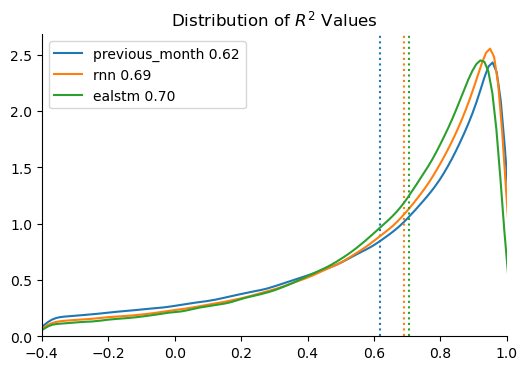

In [146]:
fig, ax = plt.subplots()

for ix, model in enumerate(pixel_mon_r2.keys()):
    model_r2 = pixel_mon_r2[model]
    color = sns.color_palette()[ix]
    median_score = float(model_r2.median().values)
    sns.distplot(
        drop_nans_and_flatten(model_r2), 
        hist=False,
#         bins = np.linspace(-0.4, 1, 100),
#         hist_kws={"range": (-0.4, 1),},
        kde_kws={"clip": (-0.4, 1)}, 
        ax=ax, 
        label=f"{model} {median_score:.2f}", 
        color=color
    )
    ax.axvline(median_score, color=color, ls=":")
    
ax.set_xlim(-0.4, 1)
ax.set_title("Distribution of $R^2$ Values")
ax.legend()
sns.despine()

In [147]:
# for ix, model in enumerate(pixel_mon_r2.keys()):
all_mth_values = []
for mth in np.arange(1, 13):
    all_mth_values.append(drop_nans_and_flatten(pixel_mon_r2[model].sel(time=mth)))
    
all_mth_values = pd.DataFrame(all_mth_values).T
all_mth_values = all_mth_values.rename(dict(zip(np.arange(12), np.arange(1, 13))), axis=1)

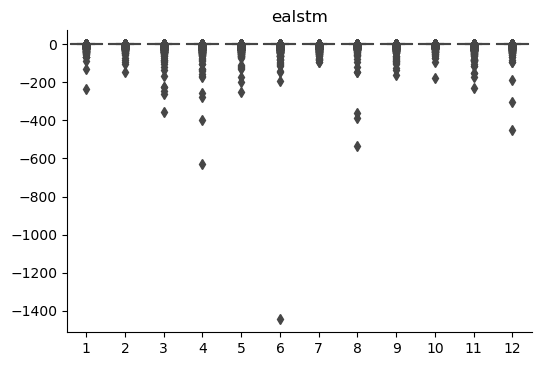

In [148]:
fig, ax = plt.subplots()
sns.boxplot(data=all_mth_values, orient="v", ax=ax)
ax.set_title(model)
# plt.yscale('log')
sns.despine()

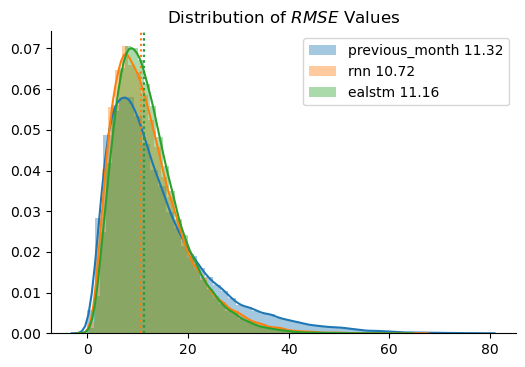

In [149]:
fig, ax = plt.subplots()

for ix, model in enumerate(pixel_mon_rmse.keys()):
    model_rmse = pixel_mon_rmse[model].sel(time=mth)
    color = sns.color_palette()[ix]
    median_score = float(model_rmse.median().values)
    sns.distplot(
        drop_nans_and_flatten(model_rmse), 
        # hist_kws={"range": (-0.4, 1)}, 
        ax=ax, 
        label=f"{model} {median_score:.2f}", 
        norm_hist=True, 
        color=color
    )  #  kde_kws={"clip": (0, 1)}, 
    ax.axvline(median_score, color=color, ls=":")
    
# ax.set_xlim(-0.4, 1)
ax.set_title("Distribution of $RMSE$ Values")
ax.legend()
sns.despine()

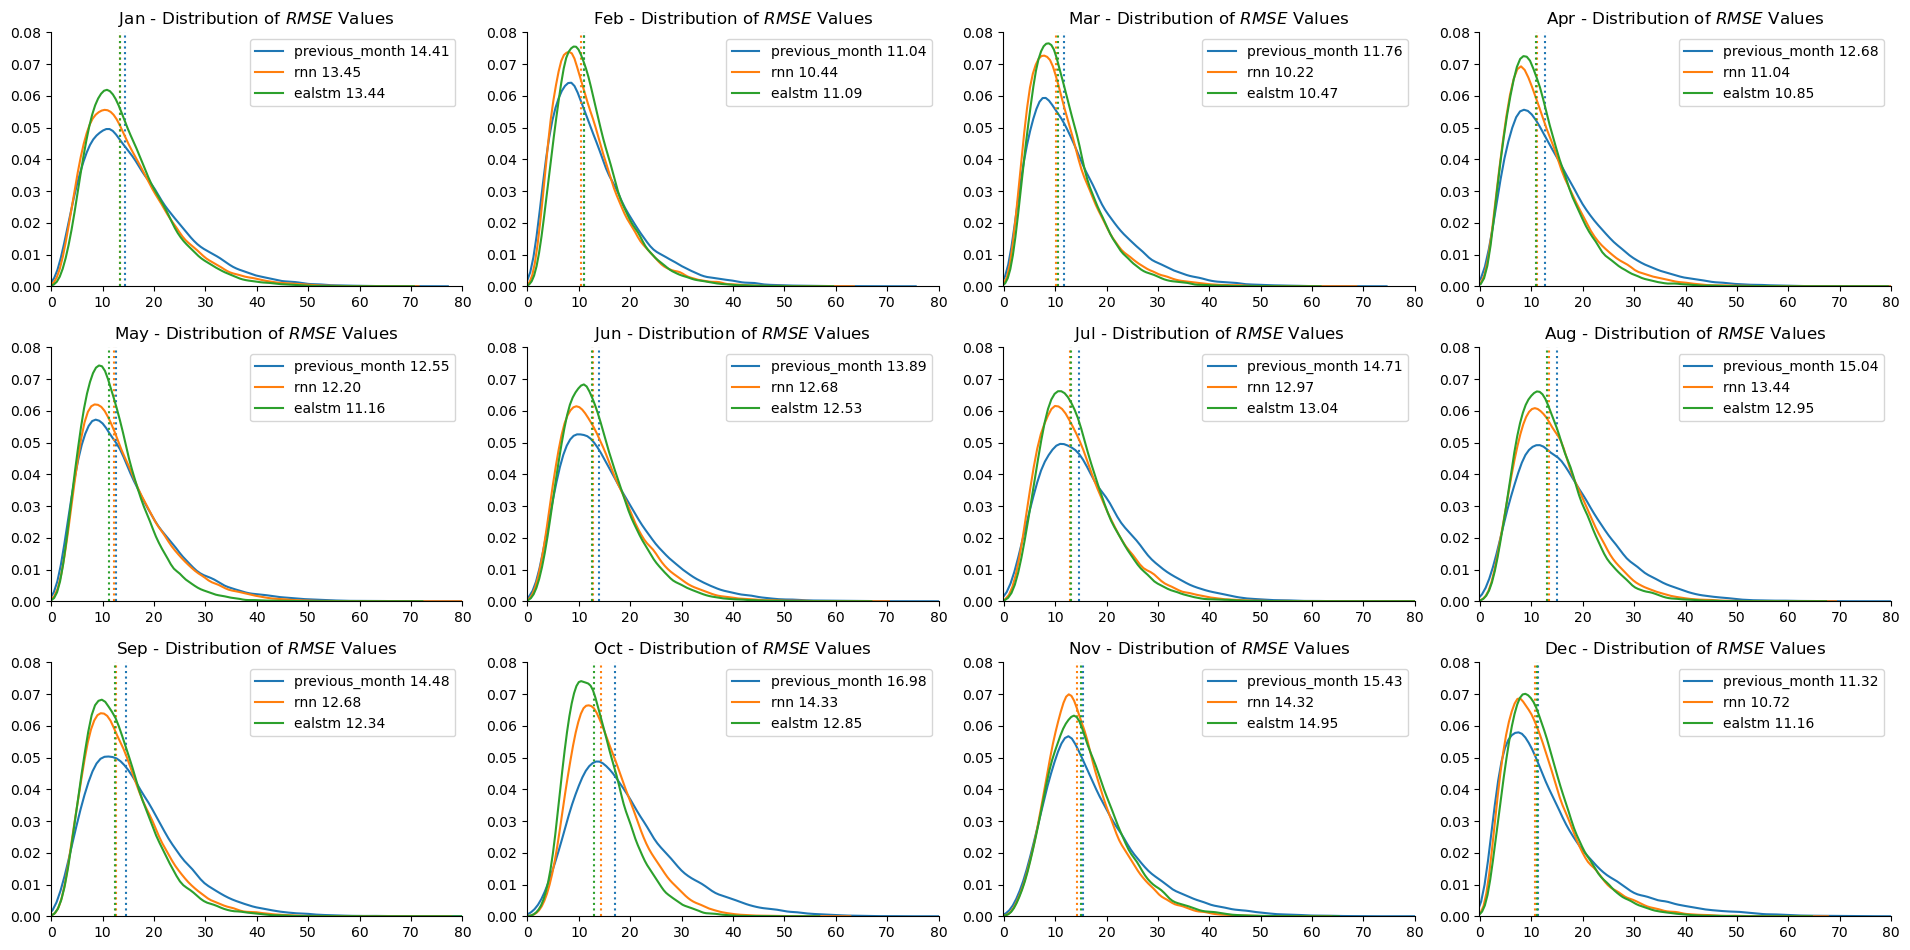

In [150]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        model_rmse = pixel_mon_rmse[model].sel(time=mth)
        color = sns.color_palette()[ix]
        median_score = float(model_rmse.median().values)
        sns.distplot(
            drop_nans_and_flatten(model_rmse), 
            # hist_kws={"range": (-0.4, 1)}, 
            hist=False,
            ax=ax, 
            label=f"{model} {median_score:.2f}", 
            norm_hist=True, 
            color=color
        )  #  kde_kws={"clip": (0, 1)}, 
        ax.axvline(median_score, color=color, ls=":")

    ax.set_xlim(-0.1, 80)
    ax.set_ylim(0, 0.08)
    ax.set_title(f"{calendar.month_abbr[mth]} - Distribution of $RMSE$ Values")

    ax.legend()
    sns.despine()

plt.tight_layout()

## Comparison of different metrics

In [ ]:
l1_monmean_pred_scores.head()
l2_monmean_pred_scores.head()

In [ ]:
l2_monmeans = l2_monmean_pred_scores[["month", "model", "rmse", "r2_score"]].groupby(["month", "model"]).mean()
l1_monmeans = l1_monmean_pred_scores[["month", "model", "rmse", "r2_score"]].groupby(["month", "model"]).mean()

In [ ]:
sns.palplot(sns.color_palette('viridis', 18))

In [ ]:
colors = sns.color_palette('viridis', 18)
c_lkup = {
    "ealstm_l1": colors[0], 
    "ealstm_l2": colors[3], 
    "rnn_l1": colors[13], 
    "rnn_l2": colors[14], 
    "previous_month_l1": colors[16], 
    "previous_month_l2": colors[17], 
}

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

for model in l1_monmeans.reset_index().model.unique():
    df1 = l1_monmeans.reset_index().query(f"model == '{model}'")
    df2 = l2_monmeans.reset_index().query(f"model == '{model}'")
    months = np.arange(1, 13)
    ax.plot(months, df1["rmse"], color=c_lkup[f"{model}_l1"], label=f"{model}_l1")
    ax.plot(months, df2["rmse"], color=c_lkup[f"{model}_l2"], label=f"{model}_l2")
    
ax.legend()
ax.set_ylabel("RMSE")
ax.set_xlabel("Month")
sns.despine()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

for model in l1_monmeans.reset_index().model.unique():
    df1 = l1_monmeans.reset_index().query(f"model == '{model}'")
    df2 = l2_monmeans.reset_index().query(f"model == '{model}'")
    months = np.arange(1, 13)
    ax.plot(months, df1["r2_score"], color=c_lkup[f"{model}_l1"], label=f"{model}_l1")
    ax.plot(months, df2["r2_score"], color=c_lkup[f"{model}_l2"], label=f"{model}_l2")
    
ax.legend()
ax.set_ylabel("$R^2$")
ax.set_xlabel("Month")
sns.despine()

## Monthly Mean Errors over each AdminUnit

### STATE L1

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        data = l1_monmean_pred_scores.query(f"(model == '{model}') & (month == {mth})").rmse
        median_score = float(data.median())
        sns.distplot(
            data,
            kde_kws={"clip": (0, 30)},
            ax=ax,
            hist=False,
            label=f"{model} {median_score:.2f}",
        )

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.2)
    ax.set_title(f"{model} State (L1) Mean RMSE")
    ax.legend()
    sns.despine()
    
plt.tight_layout()

### District L2

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(6*scale*4, 4*scale*3))

for mth in np.arange(1, 13):
    ax = axs[np.unravel_index(mth-1, (3, 4))]
    
    for ix, model in enumerate(pixel_mon_rmse.keys()):
        data = l2_monmean_pred_scores.query(f"(model == '{model}') & (month == {mth})").rmse
        median_score = float(data.median())
        sns.distplot(
            data,
            kde_kws={"clip": (0, 30)},
            ax=ax,
            hist=False,
            label=f"{model} {median_score:.2f}",
        )

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.2)
    ax.set_title(f"{model} District (L2) Mean RMSE")
    ax.legend()
    sns.despine()
    
plt.tight_layout()

# Check the spatial boundaries

In [91]:
from scripts.analysis import create_region_lookup_dict

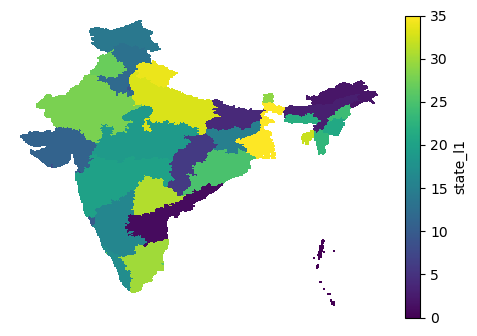

In [93]:
region_lookup = create_region_lookup_dict(l1_mask)

fig, ax = plt.subplots()
l1_mask["state_l1"].plot(ax=ax)
ax.axis('off');

In [109]:
state_pixels = []
states = []
for (key, state) in region_lookup.items():
    vci = test_da.isel(time=0).where(l1_mask["state_l1"] == key, drop=True)
    vci = vci.to_dataframe().dropna()
    
    # append to lists
    state_pixels.append(len(vci))
    states.append(state)

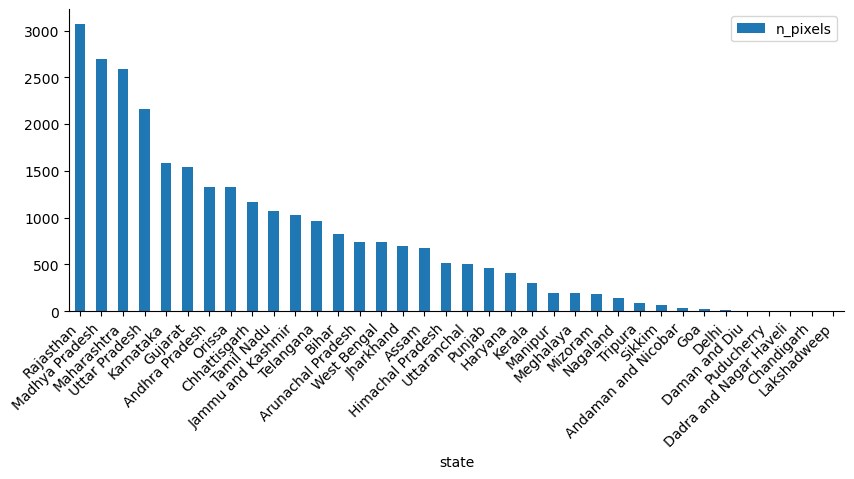

In [123]:
fig, ax = plt.subplots(figsize=(10, 4))
df_pixels = pd.DataFrame({"state": states, "n_pixels": state_pixels}).set_index("state")
df_pixels.sort_values("n_pixels", ascending=False).plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
sns.despine()

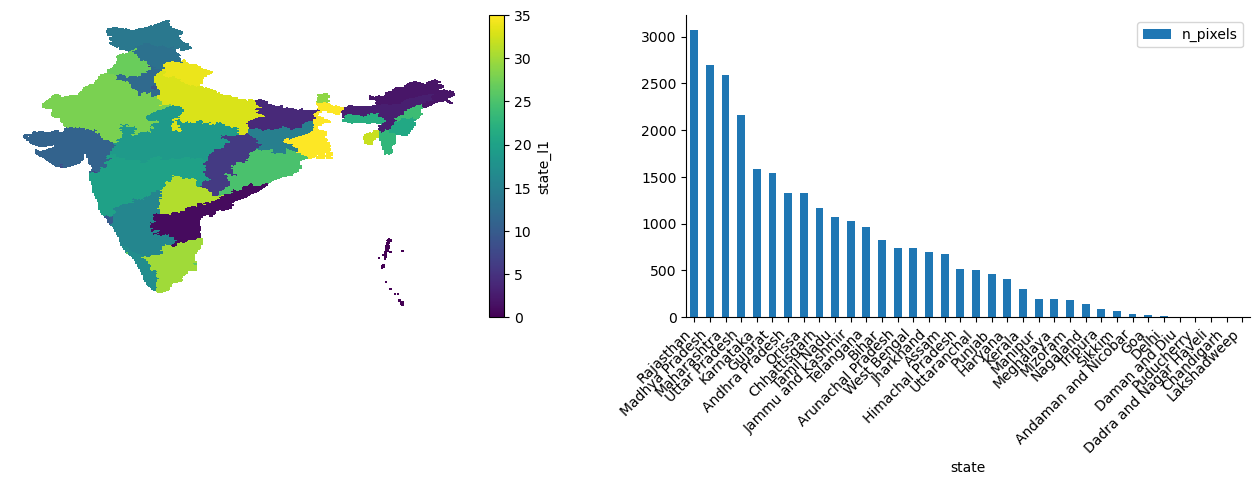

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(8*2, 4))
ax = axs[0]
l1_mask["state_l1"].plot(ax=ax)
ax.axis('off');

ax = axs[1]
df_pixels.sort_values("n_pixels", ascending=False).plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
sns.despine()

In [129]:
len(region_lookup.values())

36

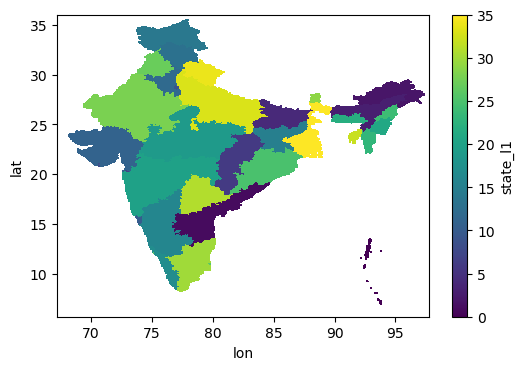